<div class="row">
  <div class="column">
<img align="left" width="200" height="42" src="https://assets.ensam.eu/logo/fr/logo-trans-322x84.png" />  </div>
  <div class="column">
<img align="right" width="120" height="42" src="https://upload.wikimedia.org/wikipedia/commons/b/bd/CC-BY-NC-SA.svg"/>  </div>
</div>

Jean-Christophe Loiseau  
Maître de Conférences  
&#128231; : jean-christophe.loiseau@ensam.eu  
&#128197; : 14 Janvier 2022

In [62]:
# --> Import des librairies usuelles.
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.signal import welch
from scipy.fft import ifft, fft

import pysindy as ps

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

# --> Raccourcis.
npl, npr = np.linalg, np.random

# Introduction à l'identification de systèmes non-linéaires

L'identification symbolique de systèmes non-linéaires est un champ de recherche très actif à l'interface de la théorie des systèmes dynamiques et de l'apprentissage statistique.
Alors que son pendant pour les systèmes linéaires a atteint une grande maturité théorique et technique ces vingt dernières années, il existe encore beaucoup de questions ouvertes pour l'identification de systèmes non-linéaires.
Malgré tout, d'énormes progrès ont été obtenu ces dix dernières années grâce, entre autres, aux avancées théoriques et algorithmiques liées aux méthodes de régression parcimonieuse.
Parmi ces méthodes d'identification, les plus connues sont :
- la programmation génétique, [Schmidt & Lipson](https://www.science.org/doi/abs/10.1126/science.1165893).
- Nonlinear AutoRegression Moving Average with eXogeneous models (NARMAX), [Billings](https://www.wiley.com/en-sg/Nonlinear+System+Identification:+NARMAX+Methods+in+the+Time,+Frequency,+and+Spatio+Temporal+Domains-p-9781119943594).
- Sparse Identification of Nonlinear Dynamics (SINDy), [Brunton et al.](https://www.pnas.org/content/113/15/3932).

Dans la suite de ce tutoriel, nous concentrerons nos efforts sur SINDy.
Pour cela, nous utiliserons la librairie [pySINDy](https://github.com/dynamicslab/pysindy) développée conjointement avec Steven Brunton et ses collaborateurs.

## Sparse Identification of Nonlinear Dynamics (SINDy)

**SINDy** forme un ensemble de méthodes très flexibles pour l'identification de systèmes non-linéaires.
Toutes ces méthodes reposent sur la même observation que, pour la plupart des systèmes dynamiques du type

$$
\dfrac{d \mathbf{x}}{dt} = f(\mathbf{x}),
$$

la fonction $f : \mathbb{R}^n \to \mathbb{R}^n$ est *parcimonieuse*, c'est à dire qu'elle ne fait intervenir qu'un nombre limité de termes parmi toutes les fonctions disponibles (e.g. polynômes, fonctions transcendantales, etc).
La philosphie principale est illustrée dans la figure ci-dessous.

![](imgs/sparse_identification.png)

Considérons pour simplifier les choses que l'on cherche à identifier un modèle pour un système que nous savons être à deux degrés de liberté.
Nous avons par ailleurs une (ou plusieurs) série temporelle de ces degrés de liberté.
Il est alors possible de construire les matrices de données suivantes

$$
\mathbf{X}
=
\begin{bmatrix}
x_1(t_1) & x_2(t_1) \\
x_1(t_2) & x_2(t_2) \\
\vdots & \vdots \\
x_1(t_m) & x_2(t_m)
\end{bmatrix}
\quad \text{et} \quad \mathbf{X}^{\prime}
=
\begin{bmatrix}
\dot{x}_1(t_1) & \dot{x}_2(t_1) \\
\dot{x}_1(t_2) & \dot{x}_2(t_2) \\
\vdots & \vdots \\
\dot{x}_1(t_m) & \dot{x}_2(t_m)
\end{bmatrix}
$$

Dans un second temps, on construit une librairie de termes possibles pour approximer cette fonction $f(\mathbf{x})$ inconnue.
Une grande liberté est offerte dans la construction de cette librairie même si, en pratique, considérer des fonctions polynômiales est souvent un bon début.
Ainsi, on peut par exemple considérer la librairie suivante

$$
\Theta(x_1, x_2)
=
\begin{bmatrix}
1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2
\end{bmatrix}.
$$

A partir de là, il est possible d'exprimer notre système dynamique inconnu sous la forme suivante

$$
\mathbf{X}^{\prime}_i = \Theta(\mathbf{X}) \boldsymbol{\xi}_i.
$$

$\boldsymbol{\xi}_i$ est un vecteur contenant les coefficients devant chacun des termes de notre librairies de candidats.
L'objectif de l'identification symbolique est alors de trouver le vecteur $\boldsymbol{\xi}$ le plus simple possible, i.e. celui ayant le plus de coefficients nuls mais approximant malgré tout correctement la dynamique de notre système.
En théorie, ceci peut être formulée comme le problème d'optimisation suivant

$$
\begin{aligned}
\text{minimiser } & \text{card}(\boldsymbol{\xi}_i) \\
\text{sous la contrainte } & \| \mathbf{X}^{\prime} - \Theta(\mathbf{X}) \boldsymbol{\xi}_i \|_2 \leq \sigma
\end{aligned}
$$

Malheureusement ce problème est de type combinatoire.
Afin de le résoudre, il est alors nécessaire de tester toutes les combinaisons possibles de termes issus de notre librairie, une chose impossible à faire en un temps raisonnable.

Heureusement pour nous, il a été montré que des relaxations convexes à ce problème existaient.
Ainsi, au lieu de tenter de résoudre le problème ci-dessus, il est plus simple de résoudre celui ci-dessous

$$
\text{minimiser } \quad \| \mathbf{X}^{\prime} - \Theta(\mathbf{X}) \boldsymbol{\xi}_i \|_2^2 + \lambda \mathcal{R}(\boldsymbol{\xi}_i)
$$

où $\mathcal{R}(\boldsymbol{\xi}_i)$ est un terme de régularisation ayant pour objectif de promouvoir des solutions parcimonieuses.
Parmi ce type de régularisation, la plus connue est la régularisation $\ell_1$ donnant lieu à la méthode connue sous le nom de [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics)).
Un certain nombre d'autres régularisations sont proposées dans **pySINDy**, voir la documentation pour plus de détails.

In [2]:
def lorenz(t, u, p):
    # --> Unpack parameters.
    σ, ρ, β = p
    
    # --> Unpack state variables.
    x, y, z = u
    
    # --> Lorenz system.
    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x*y - β*z
    
    return dx, dy, dz

In [1165]:
# --> Paramètres du système.
σ, ρ, β = 10, 28, 8/3

# --> Condition initiale.
u0 = [1.0, -1.0, 20.0]

# --> Paramètres pour la simulation.
Δt = 0.01 # Pas de temps.
t = np.arange(1000 // Δt) * Δt
tspan = (t.min(), t.max())

# --> Simulation.
output = solve_ivp(
    lambda t, u : lorenz(t, u, [σ, ρ, β]),
    tspan,
    u0,
    t_eval=t,
    method="DOP853",
    atol=1e-10,
    rtol=1e-10
)

[(0.0, 50.0), Text(0.5, 0, 'Time')]

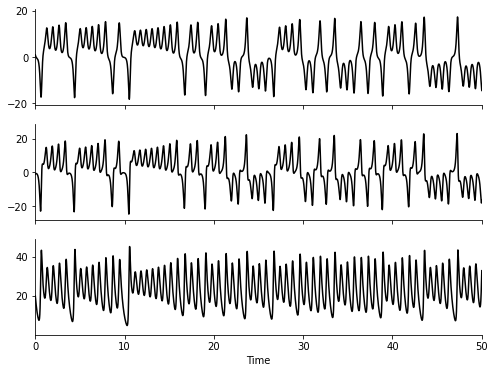

In [1166]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 6))

for i, ax in enumerate(axes):
    ax.plot(output["t"], output["y"][i], color="black")
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
axes[-1].set(xlim=(0, 50), xlabel="Time")

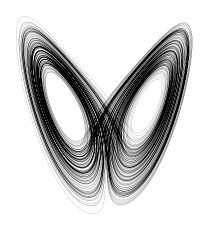

In [1227]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(output["y"][0][:len(t)//4], output["y"][-1][:len(t)//4], color="black", lw=0.1)

ax.set_aspect("equal")
ax.axis("off");

#### Chaîne de Markov

In [1168]:
X = output["y"].T

In [1169]:
cluster = KMeans(n_clusters=16)
cluster.fit(X)

KMeans(n_clusters=16)

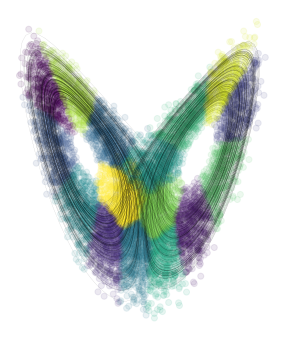

In [1233]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
stride = 10
ax.plot(output["y"][0][:len(t)//4], output["y"][-1][:len(t)//4], color="black", lw=0.1, alpha=0.5)
ax.scatter(X[::stride, 0], X[::stride, 2], c=cluster.labels_[::stride], alpha=0.1)
ax.set_aspect("equal")
ax.axis("off");

In [1171]:
p = OneHotEncoder().fit_transform(cluster.labels_.reshape(-1, 1)).toarray().T

In [1172]:
L = p[:, 1:] @ npl.pinv(p[:, :-1])

In [1173]:
λ, v = npl.eig(L)

[(0.75, 1.1)]

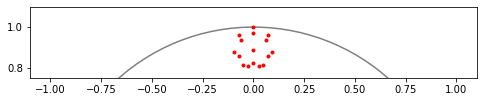

In [1174]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))

ax.plot(np.cos(θ:=np.linspace(0, 2*np.pi, 128)), np.sin(θ), color="gray")
ax.plot(λ.imag, λ.real, "r.")
ax.set_aspect("equal")

ax.set(ylim=(0.75, 1.1))

In [1175]:
U, Σ, Vt = npl.svd(L)
c = Vt @ p

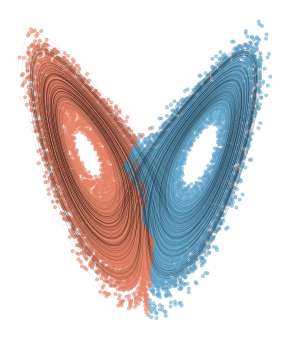

In [1239]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
stride = 5
ax.plot(output["y"][0][:len(t)//4], output["y"][-1][:len(t)//4], color="black", lw=0.1, alpha=0.5)
ax.scatter(X[::stride, 0], X[::stride, 2], marker=".", alpha=0.5, c=np.sign(c[1, ::stride]), cmap="RdBu", vmin=-2, vmax=2)

ax.set_aspect("equal")
ax.axis("off");

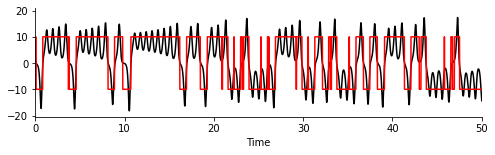

In [1242]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.plot(t, X[:, 0], color="black")
ax.plot(t, np.sign(c[1].real) * 10, color="red")
ax.set_xlim(0, 50)
ax.set_xlabel("Time")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

[[<matplotlib.axis.XTick at 0x7f5a0bca6830>,
 [Text(-1, 0, 'Left'), Text(1, 0, 'Right')]]

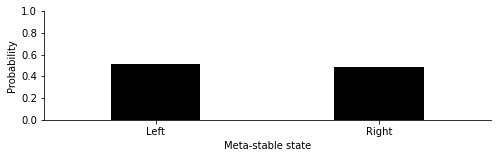

In [1254]:
idx = np.sum(c[1] < 0)
idy = np.sum(c[1] > 0)

fig, ax = plt.subplots(1, 1, figsize=(8, 2))

ax.bar([-1, 1], [idx / (idx+idy), idy / (idx+idy)], color="black")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set(ylim=(0, 1), ylabel="Probability")
ax.set(xlim=(-2, 2), xlabel="Meta-stable state")
ax.set(xticks=[-1, 1], xticklabels=["Left", "Right"])

In [1201]:
def autocorr(x):
    _, Pxx = welch(x, nperseg=4096)
    Rxx = fft(Pxx).real
    return Rxx

In [1202]:
Rxx = autocorr(X[:, 0])
Ryy = autocorr(np.sign(c[1]))

[(-1.0, 1.0), Text(0, 0.5, 'R(τ)')]

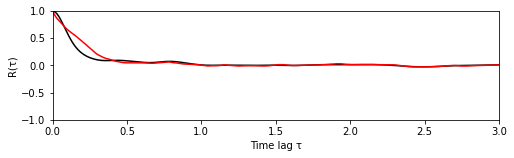

In [1257]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))

ax.plot(np.arange(len(Rxx)) * Δt, Rxx / Rxx.max(), color="black")
ax.plot(np.arange(len(Ryy)) * Δt, Ryy / Ryy.max(), color="red")

ax.set(xlim=(0, 3), xlabel="Time lag τ")
ax.set(ylim=(-1, 1), ylabel="R(τ)")

#### SINDy

In [1292]:
# --> Extrait les variables d'état.
X = output["y"].T

# --> Partage entre jeu d'entraînement et jeu de test.
X_train, X_test = X[:3*len(X)//4], X[3*len(X)//4:]
t_train, t_test = t[:3*len(t)//4], t[3*len(t)//4:]

# --> Librairie polynomiale.
Θ = ps.PolynomialLibrary(degree=3)

# --> Optimizer.
opt = ps.SR3()

# --> SINDy model.
model = ps.SINDy(
    optimizer=opt,
    feature_library=Θ,
    feature_names=["x", "y", "z"]
)

model.fit(X_train, t_train)
model.print()

(x)' = -9.978 x + 9.978 y
(y)' = 27.800 x + -0.961 y + -0.994 x z
(z)' = -2.659 z + 0.997 x y


In [1265]:
# --> Simule le modèle identifié.
Y = model.simulate(X_test[0], t_test)

[(749.99, 799.99), Text(0.5, 0, 'Time')]

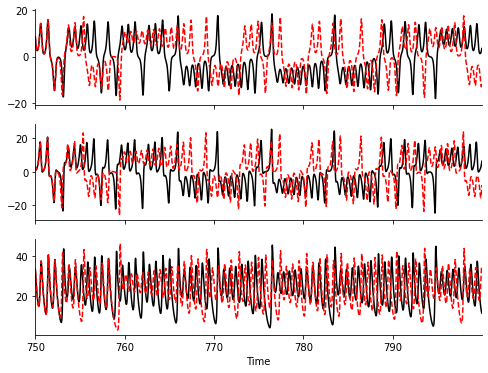

In [1266]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 6))

for i, ax in enumerate(axes):
    ax.plot(t_test, X_test[:, i], color="black")
    ax.plot(t_test, Y[:, i], color="red", ls='--')
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
axes[-1].set(xlim=(t_test.min(), t_test.min() + 50), xlabel="Time")

(-20.780642450731143,
 20.705205075669884,
 0.9291721304733533,
 48.667530396692726)

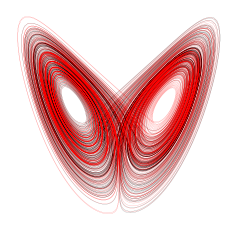

In [1267]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(X_test[:, 0], X_test[:, -1], color="black", lw=0.1)
ax.plot(Y[:, 0], Y[:, -1], color="red", lw=0.1)

ax.axis("off")